In [2]:
import torch
import numpy as np
from transformers import AutoProcessor, XCLIPVisionModel
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from pathlib import Path
import pandas as pd
import numpy as np
from torchvision.transforms import RandomResizedCrop,  Compose, Normalize, ToTensor, Resize

In [18]:
data = load_dataset('TornikeO/imigue', )

Generating train split:   0%|          | 0/60514 [00:00<?, ? examples/s]

In [19]:
data['train'][:10]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

['arms_akimbo',
 'biting_nails',
 'buckle_button,_pulling_shirt_collar,_adjusting_tie',
 'bulging_face,_deep_breath',
 'covering_face',
 'crossing_fingers',
 'dustoffing_clothes',
 'folding_arms',
 'head_up',
 'hold_back_arms',
 'illustrative_body_language',
 'minaret_gesture',
 'moving_torso',
 'playing_with_or_adjusting_hair',
 'playing_with_or_manipulating_objects',
 'pressing_lips',
 'putting_arms_behind_body',
 'rubbing_eyes',
 'rubbing_or_holding_hands',
 'scratching_back',
 'scratching_or_touching_arms',
 'shaking_shoulders',
 'sitting_upright',
 'touching_ears',
 'touching_hat',
 'touching_jaw',
 'touching_or_covering_suprasternal_notch',
 'touching_or_scratching_facial_parts',
 'touching_or_scratching_forehead',
 'touching_or_scratching_head',
 'touching_or_scratching_neck',
 'turtle_neck']

['arms_akimbo', 'biting_nails', 'buckle_button,_pulling_shirt_collar,_adjusting_tie', 'bulging_face,_deep_breath', 'covering_face', 'crossing_fingers', 'dustoffing_clothes', 'folding_arms', 'head_up', 'hold_back_arms', 'illustrative_body_language', 'minaret_gesture', 'moving_torso', 'playing_with_or_adjusting_hair', 'playing_with_or_manipulating_objects', 'pressing_lips', 'putting_arms_behind_body', 'rubbing_eyes', 'rubbing_or_holding_hands', 'scratching_back', 'scratching_or_touching_arms', 'shaking_shoulders', 'sitting_upright', 'touching_ears', 'touching_hat', 'touching_jaw', 'touching_or_covering_suprasternal_notch', 'touching_or_scratching_facial_parts', 'touching_or_scratching_forehead', 'touching_or_scratching_head', 'touching_or_scratching_neck', 'turtle_neck']
torch.Size([3, 224, 224])
dict_keys(['label', 'pixel_values'])


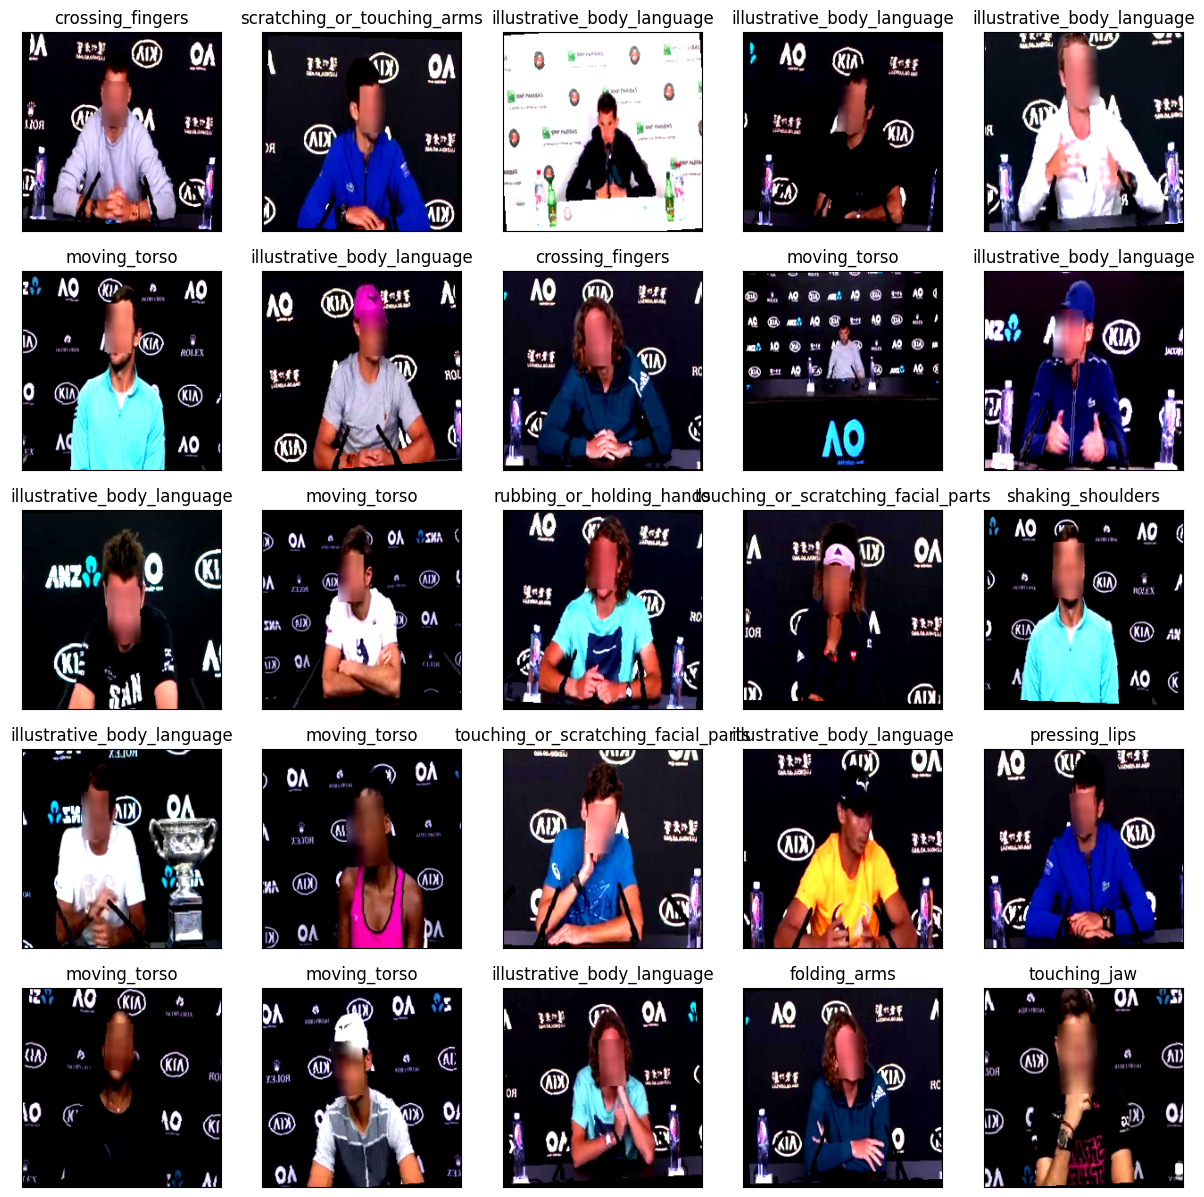

In [45]:
import torchvision.transforms as T
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

train_transforms = T.Compose([
    T.Resize(size=size),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=5,
                   translate=(0.01, 0.03),
                   scale=(.95, 1.05),),
    T.ToTensor(),
    normalize,
])

val_transforms = T.Compose([
    T.Resize(size=size),
    T.ToTensor(),
    normalize,
])

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image) for image in examples["image"]
    ]
    del examples['image']
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image) for image in examples["image"]
    ]
    del examples['image']
    return examples

id2label = data['train'].features['label'].names
label2id = dict(zip(id2label, range(len(id2label))))
print(id2label)

ds = data['train'].train_test_split(test_size=.2, stratify_by_column='label')

train_ds, val_ds = ds['train'], ds['test']
train_ds.set_transform(preprocess_train, columns=['image', 'label'], output_all_columns=False)
val_ds.set_transform(preprocess_val, columns=['image', 'label'], output_all_columns=False)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.ravel()
for i, (d, ax) in enumerate(zip(train_ds, axs.ravel())):
    if i == 0:
        print(d['pixel_values'].shape)
        print(d.keys())
    ax: plt.Axes = ax
    ax.imshow((d['pixel_values'].permute(1,2,0) + .7).clip(0,1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title(id2label[d['label']])

In [47]:
train_ds, val_ds

(Dataset({
     features: ['image', 'label'],
     num_rows: 48411
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 12103
 }))

In [40]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [41]:
import numpy as np
import evaluate


In [60]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [61]:
from sklearn.metrics import classification_report
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = accuracy.compute(predictions=predictions, references=labels)
    report = classification_report(labels, predictions, output_dict=True)
    per_class_acc = {f"{id2label[class_id]}": report[str(class_id)]['precision'] for class_id in range(len(label2id))}
    return {**acc, **f1, **per_class_acc}
  
training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    # This MIGHT seem like a crazy high number, but it's fine rtx4090 can handle it with fp16
    # Also since classes are imba, large enough batch size will make small classes contribute to grads
    # making it more likely that model will learn imba classes too
    per_device_train_batch_size=128, 
    gradient_accumulation_steps=4,  
    per_device_eval_batch_size=128 * 2, 
    dataloader_num_workers=24,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    seed=42,
    fp16=True,
    # use_cpu=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# Let's check initial acc
print(trainer.evaluate())

# Now run that mf
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 3.481083631515503, 'eval_accuracy': 0.022308518549120054, 'eval_f1': 0.011607841798121129, 'eval_arms_akimbo': 0.0037243947858473, 'eval_biting_nails': 0.0, 'eval_buckle_button,_pulling_shirt_collar,_adjusting_tie': 0.009900990099009901, 'eval_bulging_face,_deep_breath': 0.0, 'eval_covering_face': 0.0, 'eval_crossing_fingers': 0.0, 'eval_dustoffing_clothes': 0.0, 'eval_folding_arms': 0.0, 'eval_head_up': 0.0006369426751592356, 'eval_hold_back_arms': 0.0, 'eval_illustrative_body_language': 0.18604651162790697, 'eval_minaret_gesture': 0.0, 'eval_moving_torso': 0.08169291338582677, 'eval_playing_with_or_adjusting_hair': 0.0, 'eval_playing_with_or_manipulating_objects': 0.039473684210526314, 'eval_pressing_lips': 0.10249307479224377, 'eval_putting_arms_behind_body': 0.0, 'eval_rubbing_eyes': 0.0, 'eval_rubbing_or_holding_hands': 0.0, 'eval_scratching_back': 0.0, 'eval_scratching_or_touching_arms': 0.08771929824561403, 'eval_shaking_shoulders': 0.0, 'eval_sitting_upright': 0.0

Epoch,Training Loss,Validation Loss


## Inference

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model='model/checkpoint-756', device='cuda')

In [ ]:
data = load_dataset('TornikeO/imigue',)

In [ ]:
from IPython.display import display
for i in range(0, 10_000, 500):
    sample = data['train'][i]
    sample_img = data['train'][i]['image']
    sample_class = data['train'][i]['class'] - 1 # Don't forget this!
    sample_class = id2label[sample_class]
    print('Actual class ',  sample_class)
    display(sample_img)
    pred = classifier(sample_img)
    # Predictions are pretty crap!
    print(pred)